In [20]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe
from pandas.api.types import CategoricalDtype

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

In [21]:
# Font veranderen. 
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [22]:
base_path = '../processed_data/load_testing_soak'
scenarios = ['1_register_fake_data', '2_register_and_create_transaction', '3_login', '4_login_and_get_transactions']

# Human readable titles for the scenarios.  
scenario_desriptions = {
    '1_register_fake_data': 'Registreren',
    '2_register_and_create_transaction': 'Transactie aanmaken',
    '3_login': 'Inloggen',
    '4_login_and_get_transactions': 'Alle transacties ophalen',
}

Calculate mean and standard deviation.

In [24]:
for scenario in scenarios: 
    before = pd.read_csv(filepath_or_buffer=f'{base_path}/original/{scenario}.csv', delimiter=',', header=0, index_col=0)
    after = pd.read_csv(filepath_or_buffer=f'{base_path}/cybersecurity/{scenario}.csv', delimiter=',', header=0, index_col=0)

    before = before[before['count'] >= 30]
    after = after[after['count'] >= 30]

    before_mean = before['mean'].mean()
    before_std = before['mean'].std()

    after_mean = after['mean'].mean()
    after_std = after['mean'].std()

    print(scenario)
    print(f'before: mean={before_mean:.2f} std={before_std:.2f}')
    print(f'after: mean={after_mean:.2f} std={after_std:.2f}')
    print()


1_register_fake_data
before: mean=549.50 std=32.12
after: mean=789.50 std=80.58

2_register_and_create_transaction
before: mean=8.57 std=0.59
after: mean=12.32 std=2.42

3_login
before: mean=536.43 std=16.88
after: mean=616.04 std=47.79

4_login_and_get_transactions
before: mean=22.81 std=0.56
after: mean=28.25 std=0.92



## Visualize data

Grouped boxplot, grouped density plot and histogram.

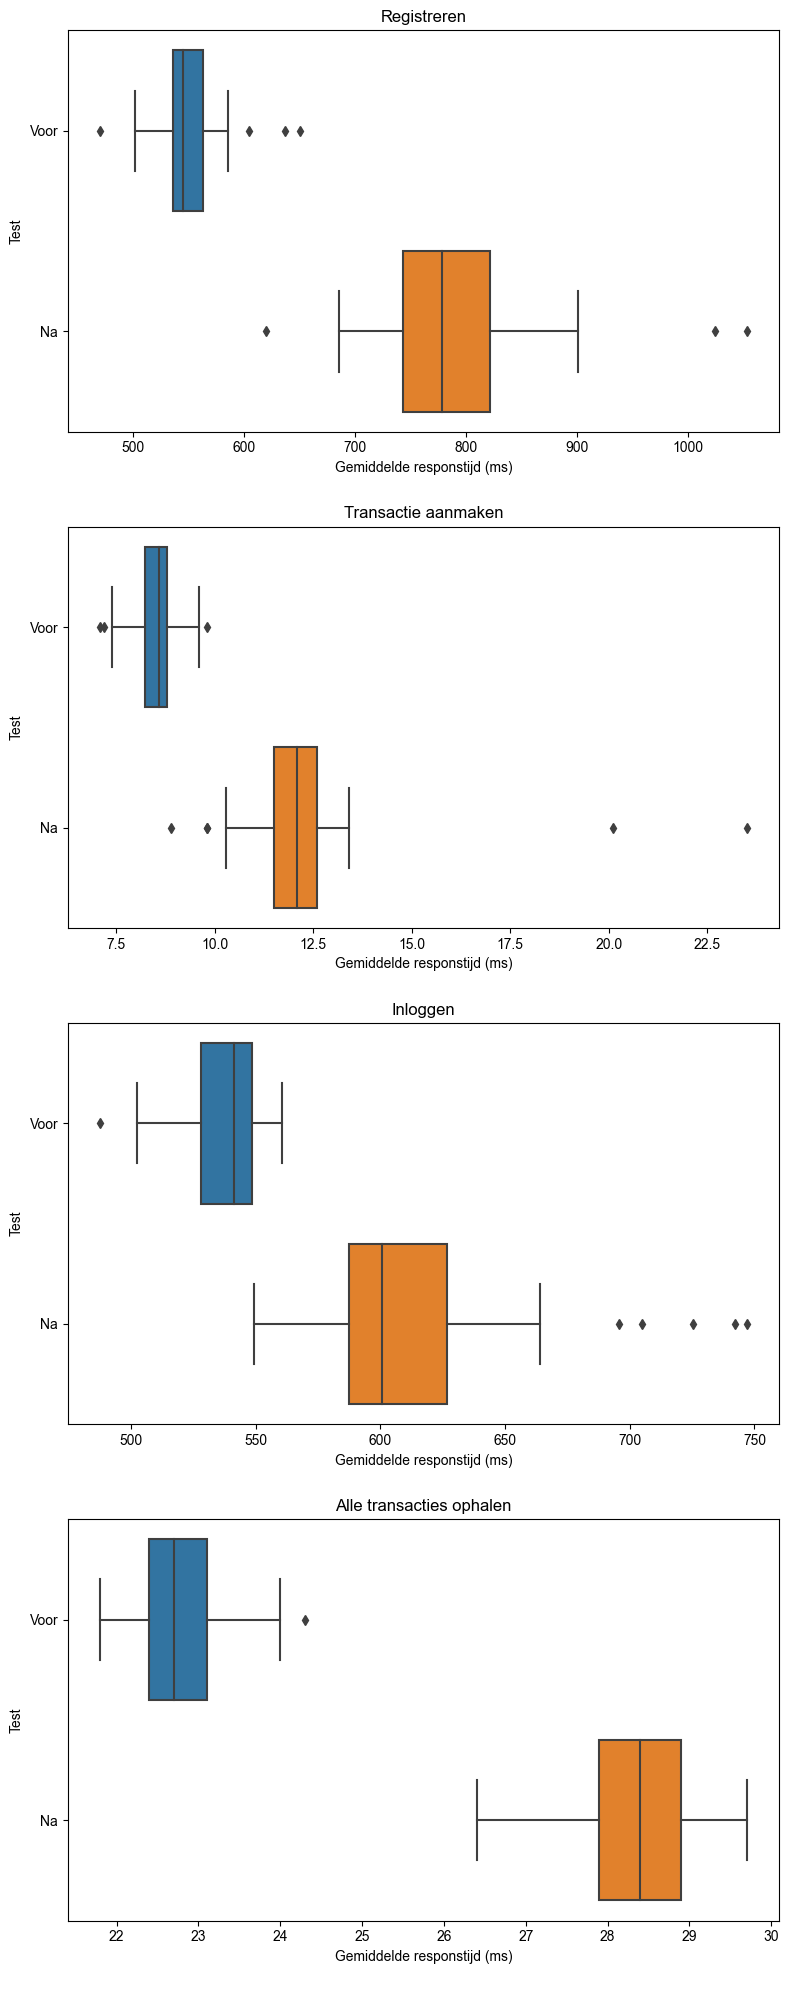

In [25]:
# Grouped boxplot.
figure, axes = plt.subplots(len(scenarios), 1, figsize=(8, 5*len(scenarios)))

for ax, scenario in zip(axes, scenarios):
    before = pd.read_csv(filepath_or_buffer=f'{base_path}/original/{scenario}.csv', delimiter=',', header=0, index_col=0)
    after = pd.read_csv(filepath_or_buffer=f'{base_path}/cybersecurity/{scenario}.csv', delimiter=',', header=0, index_col=0)

    before = before[before['count'] >= 30]
    after = after[after['count'] >= 30]

    before['source'] = 'Voor'
    after['source'] = 'Na'

    data = pd.concat([before, after])

    sns.boxplot(data=data, x='mean', y='source', ax=ax)
    # Grouped density plot. 
    # sns.kdeplot(data=data, x='mean', hue='source', ax=ax)

    ax.set_title(scenario_desriptions[scenario])

    # Add undertitle with the API method.
    # ax.text(0.5, 1.025, api_methods[scenario], ha='center', va='center', transform=ax.transAxes, family='monospace', fontsize=9)

    ax.set_xlabel('Gemiddelde responstijd (ms)\n')
    ax.set_ylabel('Test')

plt.tight_layout()
plt.show()

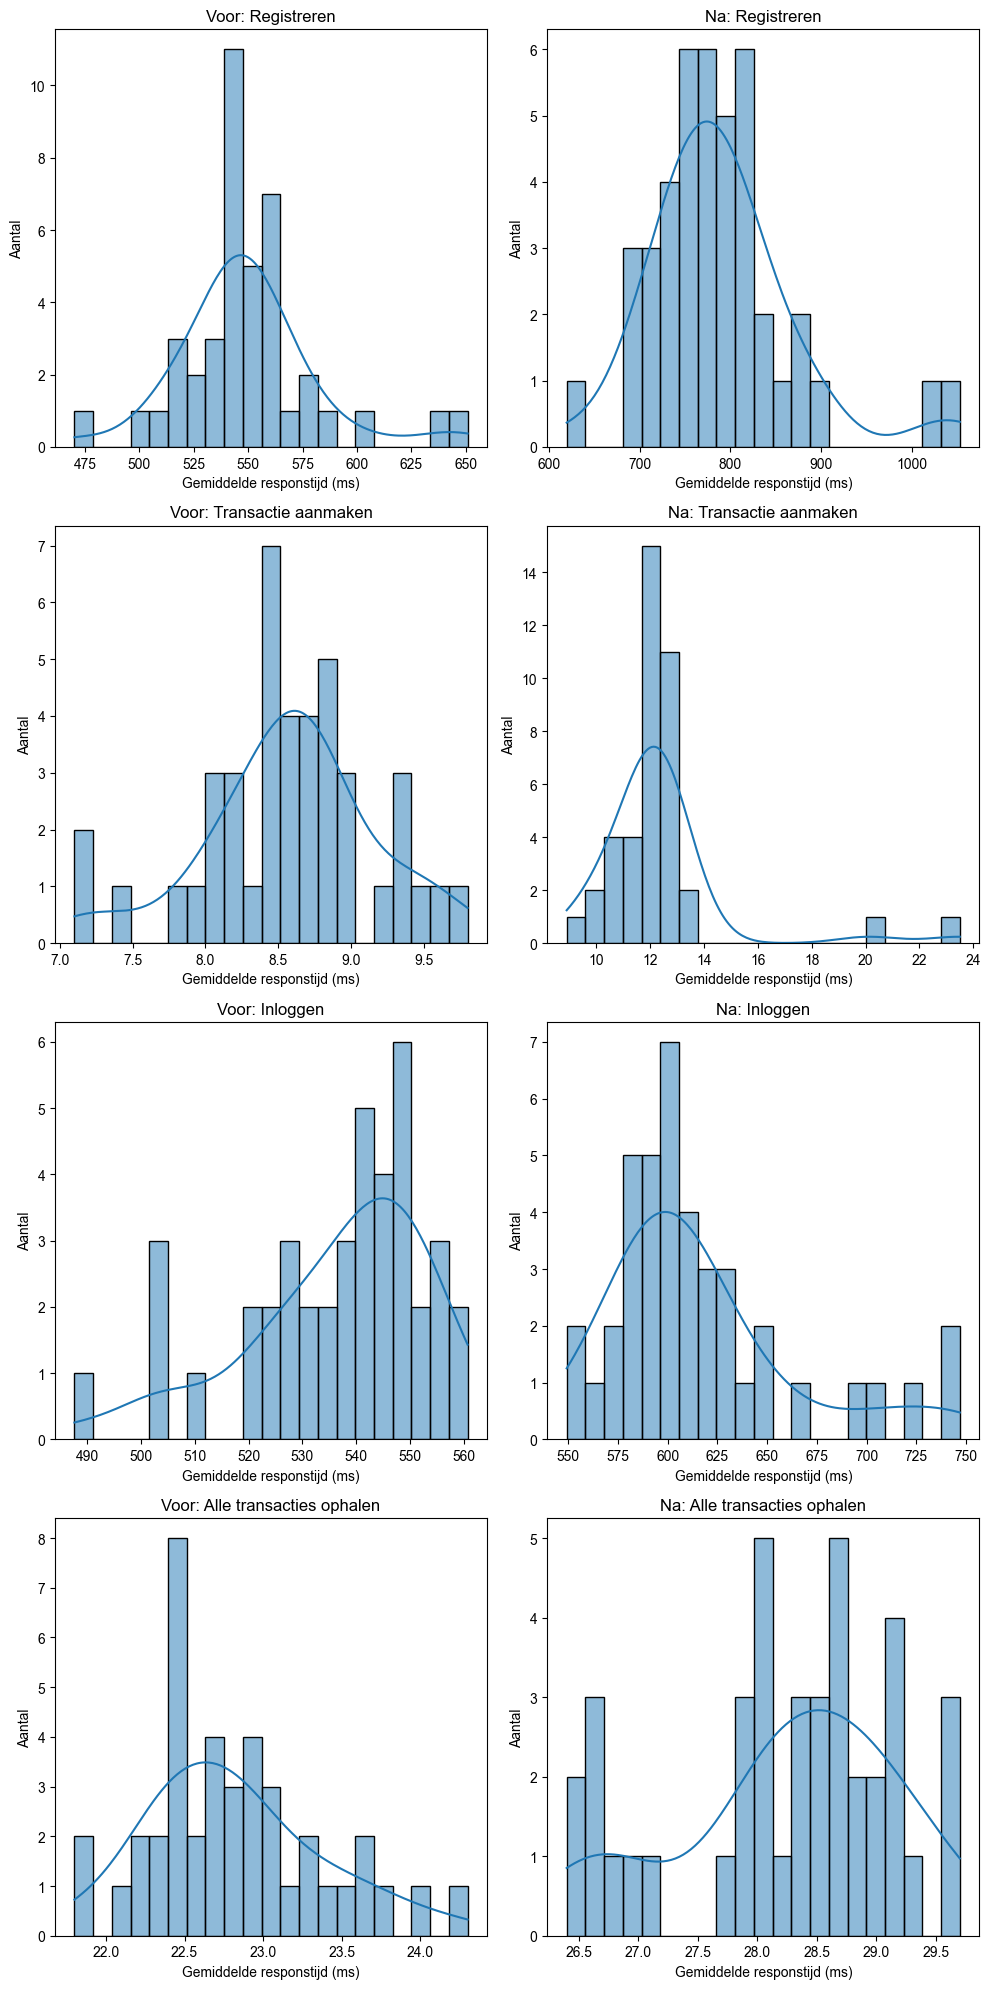

In [26]:
# Histogram. 
figure, axes = plt.subplots(len(scenarios), 2, figsize=(10, 5*len(scenarios)))

for ax, scenario in zip(axes, scenarios):
    # Before. 
    before = pd.read_csv(filepath_or_buffer=f'{base_path}/original/{scenario}.csv', delimiter=',', header=0, index_col=0)
    before = before[before['count'] >= 30]

    sns.histplot(data=before, x="mean",  bins=21, kde=True, ax=ax[0])
    ax[0].set_title(f'Voor: {scenario_desriptions[scenario]}')

    ax[0].set_xlabel('Gemiddelde responstijd (ms)')
    ax[0].set_ylabel('Aantal')

    # After.
    after = pd.read_csv(filepath_or_buffer=f'{base_path}/cybersecurity/{scenario}.csv', delimiter=',', header=0, index_col=0)
    after = after[after['count'] >= 30]

    sns.histplot(data=after, x="mean",  bins=21, kde=True, ax=ax[1])
    ax[1].set_title(f'Na: {scenario_desriptions[scenario]}')

    ax[1].set_xlabel('Gemiddelde responstijd (ms)')
    ax[1].set_ylabel('Aantal')

plt.tight_layout()
plt.show()





## Determine normality

In [27]:
alpha = 0.05

for branch in ['original', 'cybersecurity']:
    for scenario in scenarios:
        data = pd.read_csv(filepath_or_buffer=f'{base_path}/{branch}/{scenario}.csv', delimiter=',', header=0, index_col=0)
        data = data[data['count'] >= 30]  
        
        k2, p = stats.normaltest(data['mean'])
        print(f"branch={branch}\nscenario={scenario}\nnormal_distributed={p > alpha}\n")

branch=original
scenario=1_register_fake_data
normal_distributed=False

branch=original
scenario=2_register_and_create_transaction
normal_distributed=True

branch=original
scenario=3_login
normal_distributed=False

branch=original
scenario=4_login_and_get_transactions
normal_distributed=True

branch=cybersecurity
scenario=1_register_fake_data
normal_distributed=False

branch=cybersecurity
scenario=2_register_and_create_transaction
normal_distributed=False

branch=cybersecurity
scenario=3_login
normal_distributed=False

branch=cybersecurity
scenario=4_login_and_get_transactions
normal_distributed=True



## T-test for two paired samples

#### Testprocedure

**Step 1.** Formulate the hypotheses:

- $x$: before 
- $y$: after

- $H_0$: $\overline{x - y} = 0$ Cybersecurity measures **do not** have an impact on performance. 
- $H_1$: $\overline{x - y} < 0$ Cybersecurity measures **do** have an impact on performance.


**Step 2.** Choose a significance level, e.g. $\alpha = X\%$

In [28]:
alpha = .05

**Step 3 and 4.** Calculate the test statistic $\overline{x - y}$ and calculate the $p$-value:

- $x$ = Mean response time (in ms) without cybersecurity measures.
- $y$ = Mean response time (in ms) with cybersecurity measures.

In [29]:
def equalize_length(data1, data2):
    min_length = min(len(data1), len(data2))
    return data1.iloc[-min_length:], data2.iloc[-min_length:]

In [32]:
for scenario in scenarios:
    before = pd.read_csv(filepath_or_buffer=f'{base_path}/original/{scenario}.csv', delimiter=',', header=0, index_col=0)
    after = pd.read_csv(filepath_or_buffer=f'{base_path}/cybersecurity/{scenario}.csv', delimiter=',', header=0, index_col=0)

    before = before[before['count'] >= 30]
    after = after[after['count'] >= 30]

    before, after = equalize_length(before['mean'], after['mean'])

    statistic, p = stats.ttest_rel(a=before, b=after, alternative='less')
    # before is less than after. 

    print(f'Scenario: {scenario}')
    print(f'Statistic (x - y):   %.4f' % statistic)
    print(f'P-value:             {p}')
    if (p > alpha):
        print('p-value = %.4f (%.4f%%) > alpha = %.4f (%.4f%%): Do not reject H0' % (p, p*100, alpha, alpha*100))
    else:  
        print('p-value = %.4f (%.4f%%) < alpha = %.4f (%.4f%%): Reject H0' % (p, p*100, alpha, alpha*100))
    print()


Scenario: 1_register_fake_data
Statistic (x - y):   -18.9363
P-value:             7.076664301058086e-22
p-value = 0.0000 (0.0000%) < alpha = 0.0500 (5.0000%): Reject H0

Scenario: 2_register_and_create_transaction
Statistic (x - y):   -9.6194
P-value:             2.921009215847326e-12
p-value = 0.0000 (0.0000%) < alpha = 0.0500 (5.0000%): Reject H0

Scenario: 3_login
Statistic (x - y):   -11.7704
P-value:             7.172803796313185e-15
p-value = 0.0000 (0.0000%) < alpha = 0.0500 (5.0000%): Reject H0

Scenario: 4_login_and_get_transactions
Statistic (x - y):   -32.9638
P-value:             6.4613598804070945e-31
p-value = 0.0000 (0.0000%) < alpha = 0.0500 (5.0000%): Reject H0

